# 视神经节细胞编码

根据实验记录的一个神经节细胞对一系列图片输入的响应，按照课堂内容，结合两篇参考文献，建立拟合模型，解释神经元对图片刺激序列的响应模式。

## 载入数据

stimulus: 刺激图片序列，维度(359801, 50, 50)，即359801个frame，每张图片为50*50

rate: 对应的神经节细胞神经元发放率，维度(359801,)

每个frame间隔10ms

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

with open('data.pkl', 'rb') as f:
    (stimulus, rate) = pickle.load(f)

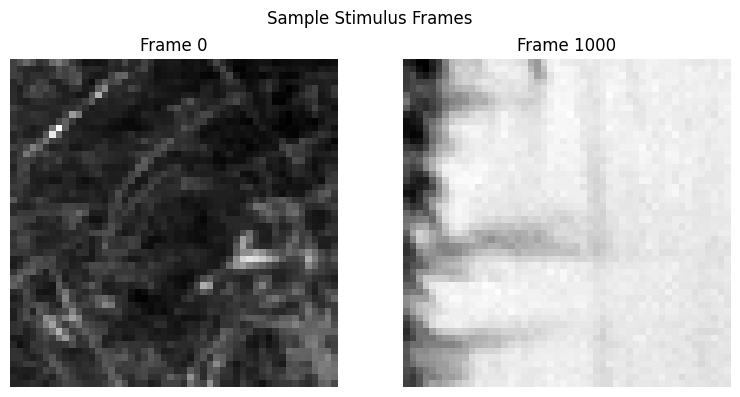

Stimulus shape: (359801, 50, 50)
Rate shape: (359801,)
Frame rate: 0.0 Hz
Time duration: 3598.01 seconds


In [2]:
# Display some frames from the stimulus
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
frame_indices = [0, 1000]  # Selecting diverse frames to display

for i, idx in enumerate(frame_indices):
    axs[i].imshow(stimulus[idx], cmap='gray')
    axs[i].set_title(f'Frame {idx}')
    axs[i].axis('off')

plt.suptitle('Sample Stimulus Frames')
plt.tight_layout()
plt.show()

# Print basic information about the data
print(f"Stimulus shape: {stimulus.shape}")
print(f"Rate shape: {rate.shape}")
print(f"Frame rate: {rate[100000]} Hz")
print(f"Time duration: {stimulus.shape[0] * 10 / 1000:.2f} seconds")

## 计算STA

### 计算并可视化spike前200ms的STA

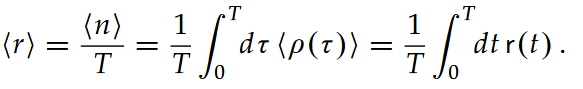

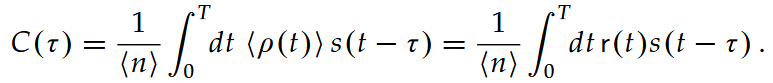

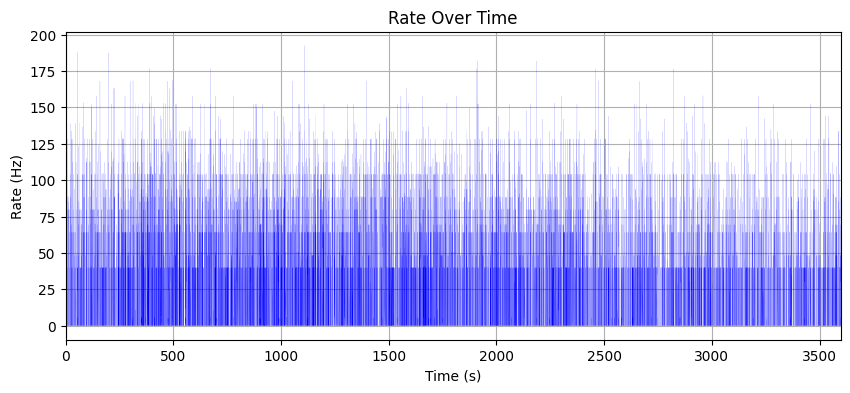

In [3]:
# Plot the rate over time
plt.figure(figsize=(10, 4))
plt.plot(np.arange(rate.shape[0]) * 10 / 1000, rate, color='blue', linewidth=0.05)
plt.title('Rate Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Rate (Hz)')
plt.xlim(0, rate.shape[0] * 10 / 1000)
plt.grid()
plt.show()

In [4]:
T, H, W = stimulus.shape
num_tau = 21 # 200ms STA i.e. 21 frames: 0 ms, 10 ms, ..., 200 ms
sum_rate = np.sum(rate)
stimulus_flat = stimulus.reshape(T, H * W) # shape: (T, H*W)

tau_indices = np.arange(num_tau)
R = np.zeros((num_tau, T))
for tau in tau_indices:
    R[tau, :T - tau] = rate[tau:]

sta_flat = (R @ stimulus_flat) / sum_rate

sta = sta_flat.reshape(num_tau, H, W)[::-1]  # Reverse the order so that sta[0] corresponds to 200ms before the spike

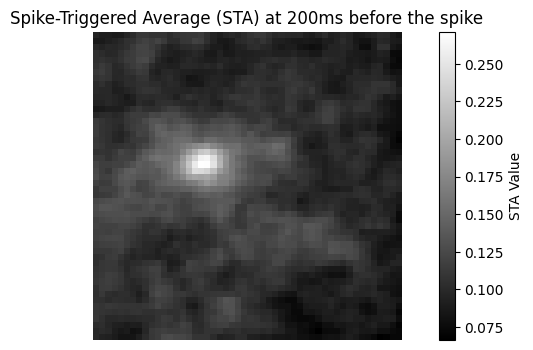

In [5]:
# Plot the STA
plt.figure(figsize=(10, 4))
plt.imshow(sta[0], cmap='gray')
plt.title('Spike-Triggered Average (STA) at 200ms before the spike')
plt.axis('off')
plt.colorbar(label='STA Value')
plt.show()

C:\Users\ItzFriiz\AppData\Local\Temp\ipykernel_10596\3779613841.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


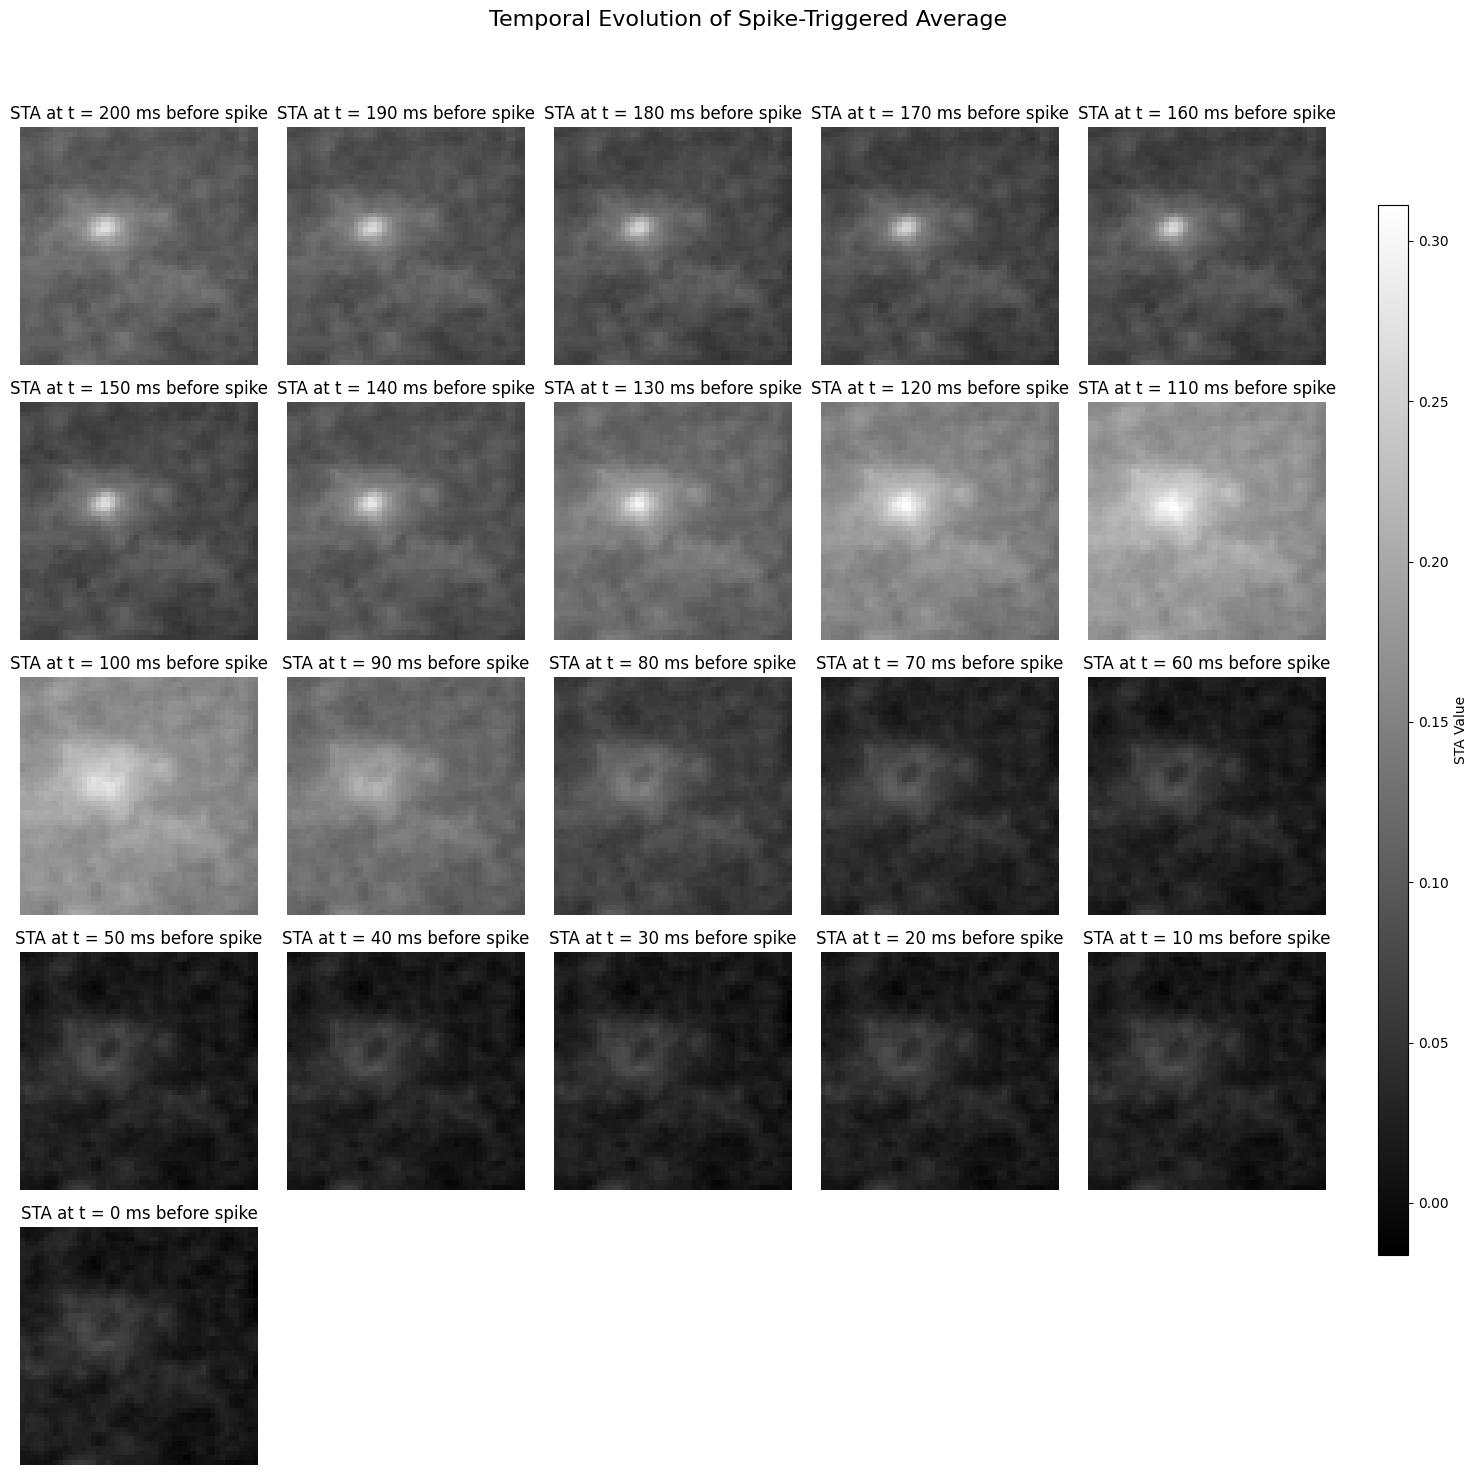

In [6]:
# Plot all STA images to observe the temporal response
fig, axes = plt.subplots(5, 5, figsize=(15, 15))  # Change to 5x5 grid to accommodate 21 frames
axes = axes.flatten()

# Create a common color scale for all panels
vmin = np.min(sta)
vmax = np.max(sta)

for i in range(num_tau):
    ax = axes[i]
    im = ax.imshow(sta[i], cmap='gray', vmin=vmin, vmax=vmax)
    ax.set_title(f'STA at t = {(num_tau-i-1)*10} ms before spike')
    ax.axis('off')

# Hide any empty subplots
for i in range(num_tau, len(axes)):
    axes[i].set_visible(False)

# Add a colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax, label='STA Value')

plt.suptitle('Temporal Evolution of Spike-Triggered Average', fontsize=16)
plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()

### 选取感受野中心和周围区域，求取空间平均值，绘制响应感受野内的STA响应曲线

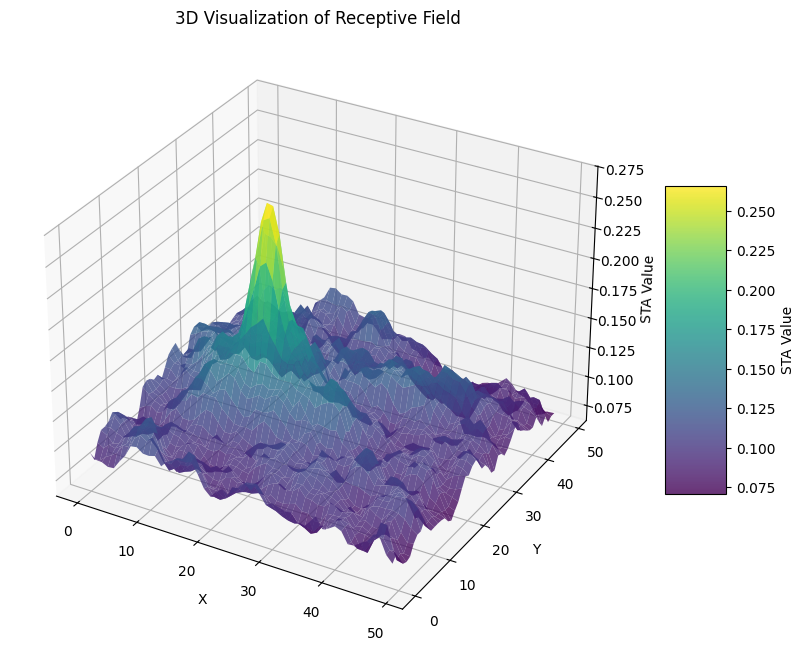

In [7]:
field = sta[0]
# Create a 3D visualization of the receptive field

# Create 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Create grid coordinates
x = np.arange(0, W)
y = np.arange(0, H)
X, Y = np.meshgrid(x, y)

# Plot the surface
surf = ax.plot_surface(X, Y, field, cmap='viridis', alpha=0.8)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('STA Value')
ax.set_title('3D Visualization of Receptive Field')
plt.colorbar(surf, ax=ax, shrink=0.5, aspect=5, label='STA Value')
plt.show()

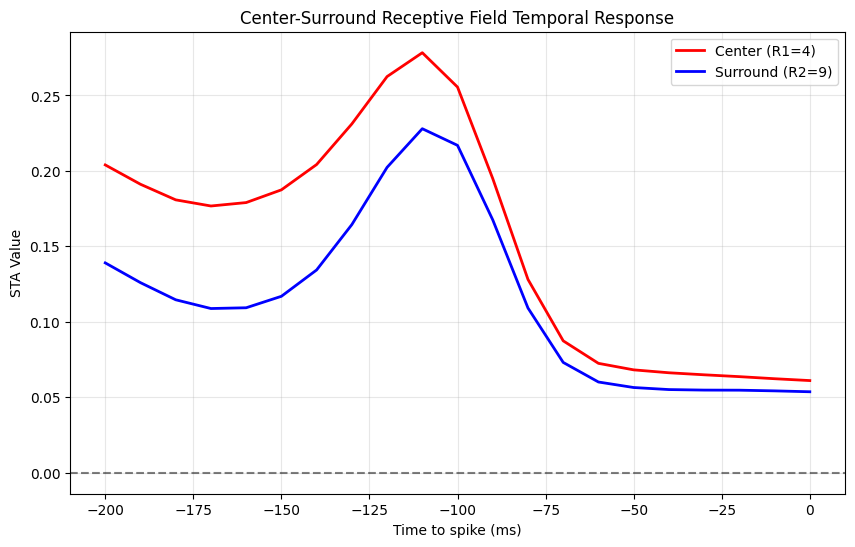

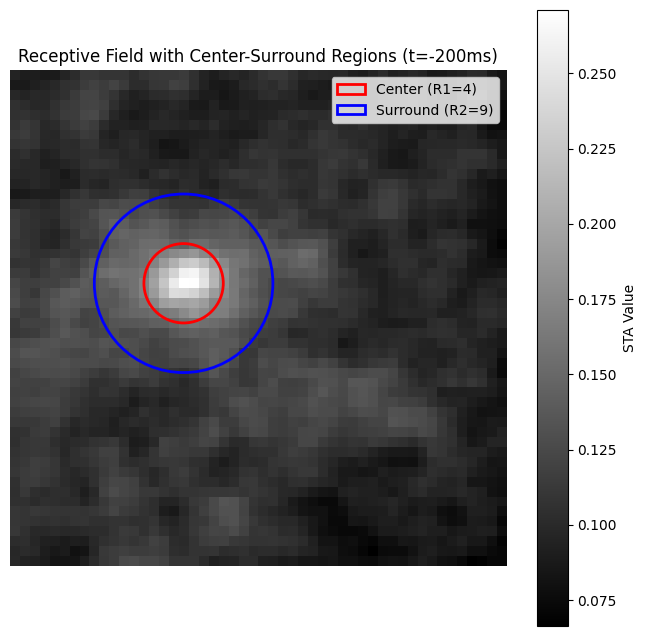

In [8]:
ori = np.array([21, 17])
R_1 = 4
R_2 = 9

# Create masks for the center and surround regions
y, x = np.ogrid[:H, :W]
dist_from_center = np.sqrt((x - ori[1])**2 + (y - ori[0])**2)

# Create masks for center and surround
center_mask = dist_from_center <= R_1
surround_mask = (dist_from_center > R_1) & (dist_from_center <= R_2)

# Extract STA values for center and surround regions
center_response = np.array([np.mean(sta[t][center_mask]) for t in range(num_tau)])
surround_response = np.array([np.mean(sta[t][surround_mask]) for t in range(num_tau)])

# Create time points for plotting (200ms to 0ms before spike)
time_points = -np.arange(num_tau)[::-1] * 10

# Plot the center and surround STA responses
plt.figure(figsize=(10, 6))
plt.plot(time_points, center_response, 'r-', linewidth=2, label='Center (R1=4)')
plt.plot(time_points, surround_response, 'b-', linewidth=2, label='Surround (R2=9)')
plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)
plt.xlabel('Time to spike (ms)')
plt.ylabel('STA Value')
plt.title('Center-Surround Receptive Field Temporal Response')
plt.legend()
plt.grid(True, alpha=0.3)

# Show the receptive field with center and surround regions
plt.figure(figsize=(8, 8))
plt.imshow(sta[0], cmap='gray')
plt.title('Receptive Field with Center-Surround Regions (t=-200ms)')

# Draw circles for center and surround regions
center_y, center_x = ori
center_outline = plt.Circle((center_x, center_y), R_1, color='r', fill=False, linewidth=2, label='Center (R1=4)')
surround_outline = plt.Circle((center_x, center_y), R_2, color='b', fill=False, linewidth=2, label='Surround (R2=9)')
plt.gca().add_patch(center_outline)
plt.gca().add_patch(surround_outline)
plt.colorbar(label='STA Value')
plt.axis('off')
plt.legend(loc='upper right')
plt.show()

## 将STA结果作为线形时空卷积核，构建从图片刺激输入到神经元发放率的拟合模型

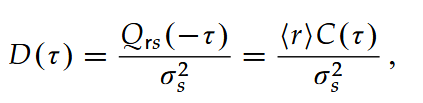

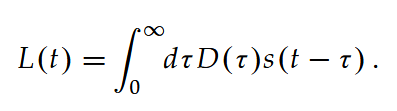

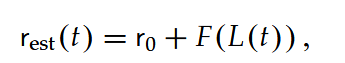

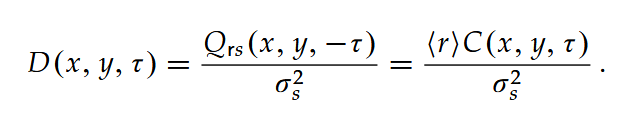

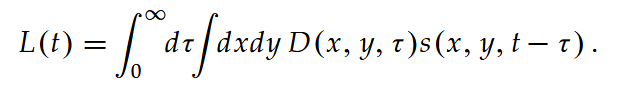

### 将该模型应用于原始刺激序列，生成对发放率的预测

In [9]:
sta = sta[::-1] # now sta[0] is the 0ms STA
sigma_s2 = np.var(stimulus, axis=0)  # shape: (H, W)

D = sta / sigma_s2[None, :, :]   # shape: (num_tau, H, W)

all_spatial_responses = np.einsum('thw,nhw->nt', stimulus, D)  # shape: (num_tau, T)
L = np.zeros(T)

In [10]:
for tau in range(num_tau):
    padded_response = np.pad(all_spatial_responses[tau], (tau, 0), mode='constant')[:T]   # shape: (T,)

    L += padded_response * 0.01 # remember d\tau!

r_est = np.maximum(0, L)

### 绘制原始发放率和拟合结果，构建指标进行评价

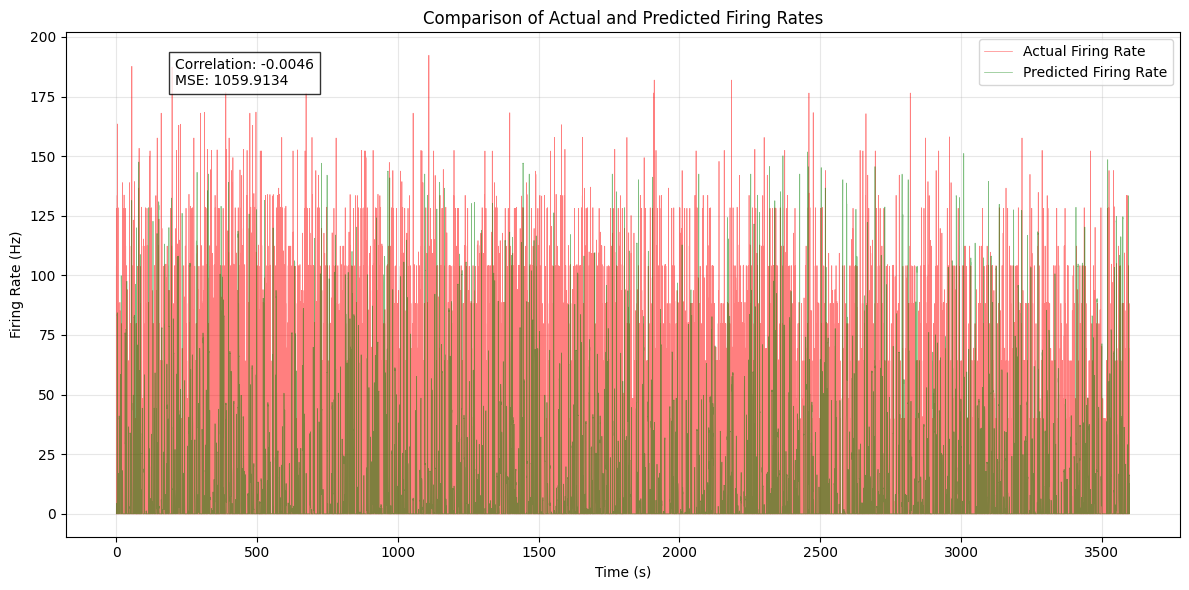

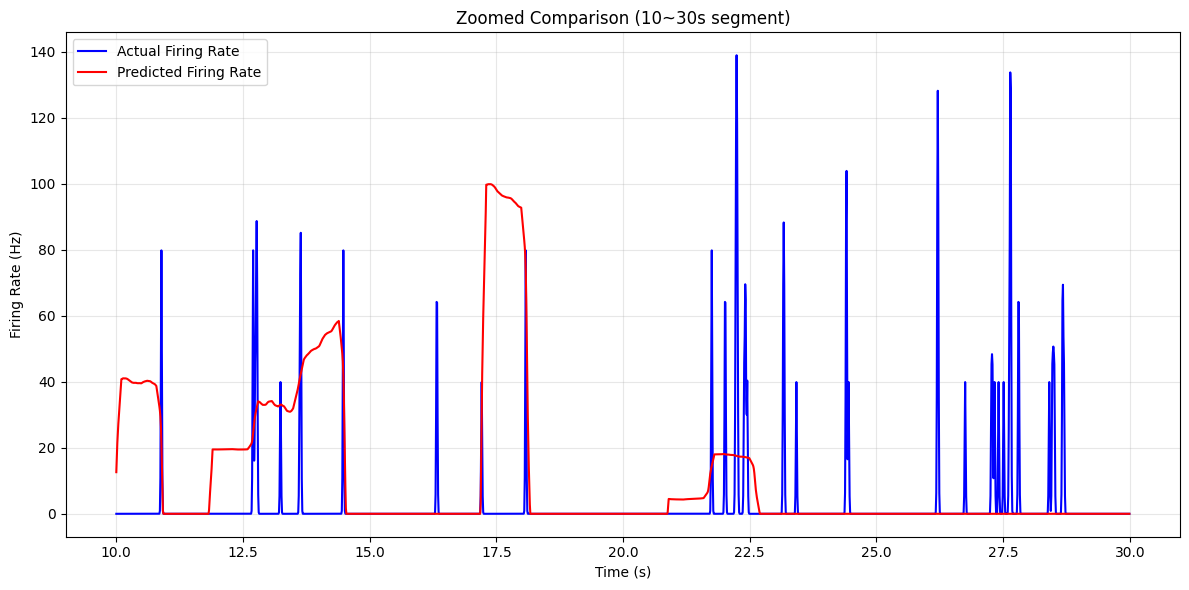

In [11]:
# Plot original firing rate and fitted results
plt.figure(figsize=(12, 6))
time_axis = np.arange(T) * 10 / 1000  # Convert to seconds

# Plot both on the same axes
plt.plot(time_axis, rate, 'r-', alpha=0.5, label='Actual Firing Rate', linewidth=0.5)
plt.plot(time_axis, r_est, 'g-', alpha=0.5, label='Predicted Firing Rate', linewidth=0.5)
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Firing Rate (Hz)')
plt.title('Comparison of Actual and Predicted Firing Rates')
plt.grid(True, alpha=0.3)

# For evaluation metrics, calculate correlation coefficient, mean squared error, and variance explained
correlation = np.corrcoef(rate, r_est)[0, 1]
mse = np.mean((rate - r_est)**2)
var_rate = np.var(rate)

# Add metrics as text
plt.figtext(0.15, 0.85, f'Correlation: {correlation:.4f}\nMSE: {mse:.4f}', bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Plot a zoom-in view of a segment to see details better
segment_start = 1000  # Start at 0
segment_length = 2000  # 20 seconds segment

plt.figure(figsize=(12, 6))
segment_time = time_axis[segment_start:segment_start+segment_length]
plt.plot(segment_time, rate[segment_start:segment_start+segment_length], 'b-', label='Actual Firing Rate')
plt.plot(segment_time, r_est[segment_start:segment_start+segment_length], 'r-', label='Predicted Firing Rate')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Firing Rate (Hz)')
plt.title('Zoomed Comparison (10~30s segment)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [12]:
print(np.max(r_est), np.min(r_est), np.mean(r_est), np.std(r_est))
print(np.max(rate), np.min(rate), np.mean(rate), np.std(rate))
print(sum_rate, T)
print(sum_rate / T)
corr = np.corrcoef(rate, r_est)[0,1]
print("预测与真实发放率的相关系数：", corr)

print(np.max(sigma_s2), np.min(sigma_s2), np.mean(sigma_s2), np.std(sigma_s2))

print(np.max(L), np.min(L), np.mean(L), np.std(L))

151.74939703737743 0.0 12.580608476741727 27.670178361942046
192.32008513428886 0.0 4.074111346974513 14.770868244204403
1465869.3367527768 359801
4.074111346974513
预测与真实发放率的相关系数： -0.004569956156799017
1.0385393 0.95824915 0.9998043 0.013944626
151.74939703737743 -39.33479674451712 0.016105543173053096 34.97443966328859


## LN 模型

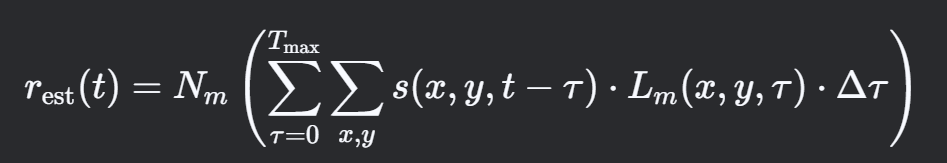

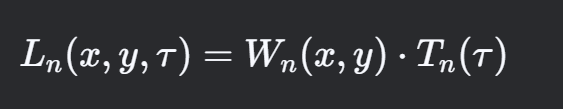

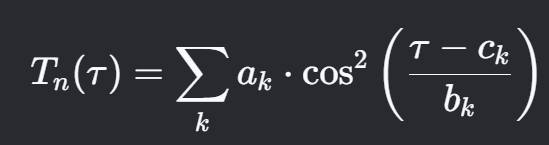

In [13]:
from scipy.interpolate import CubicSpline
from scipy.optimize import minimize

# 参数设置
num_tau = 21  # 时间滤波器长度（200ms）
num_cos_bases = 5  # 升余弦基函数数量

# 初始化空间权重 W_m (H, W)
W_m = sta.mean(axis=0) * 0.005  # shape: (H, W)

# 初始化时间滤波器 T_m (num_tau,) 为升余弦基组合
# 定义升余弦基函数
def raised_cosine(t, center, width):
    return np.cos(np.clip((t - center)/width, -np.pi/2, np.pi/2))**2

# 生成基函数参数
centers = np.linspace(0, num_tau-1, num_cos_bases)
widths = np.ones(num_cos_bases) * (num_tau / num_cos_bases)

# 时间滤波器参数 alpha (num_cos_bases,)
alpha = np.random.randn(num_cos_bases) * 0.1

# 计算 T_m
t_expanded = np.arange(num_tau)[:, None]  # shape (num_tau, 1)
def compute_T_m(alpha, centers, widths):
    return np.sum(alpha * raised_cosine(t_expanded, centers, widths), axis=1)

T_m = compute_T_m(alpha, centers, widths)

In [14]:
from scipy.ndimage import convolve1d
def compute_F(stimulus, W_m, T_m):
    spatial_response = np.einsum('thw,hw->t', stimulus, W_m)  # shape (T,)
    
    F = convolve1d(spatial_response, T_m, mode='constant', cval=0.0, origin=(len(T_m)-1)//2) * 0.01  # shape (T,)

    return F

F = compute_F(stimulus, W_m, T_m)
quantiles = np.linspace(0.05, 0.95, 6)
knots = np.quantile(F, quantiles)
spline_coeff = np.random.randn(6)

In [15]:
class NonlinearTransform:
    def __init__(self, knots, coeff):
        self.knots = knots
        self.coeff = coeff
        self.spline = CubicSpline(knots, coeff, extrapolate=True)
    
    def __call__(self, x):
        return np.clip(self.spline(x), a_min=0, a_max=None)  # 确保非负
    
N_m = NonlinearTransform(knots, spline_coeff)
r_est = N_m(F)
print(np.max(r_est), np.min(r_est), np.mean(r_est), np.std(r_est))
print(np.max(rate), np.min(rate), np.mean(rate), np.std(rate))

563.8070786455846 0.0 2.593236877475213 15.437022979566352
192.32008513428886 0.0 4.074111346974513 14.770868244204403


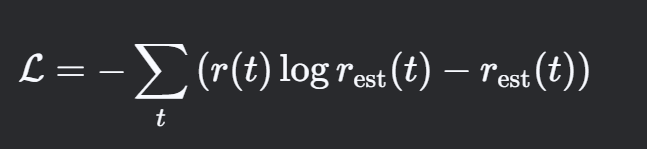

In [16]:
def neg_log_likelihood(params, stimulus, rate):
    # 解析参数
    W_m_flat, alpha, spline_coeff = params[:H*W], params[H*W:H*W+num_cos_bases], params[H*W+num_cos_bases:]
    W_m = W_m_flat.reshape(H, W)
    
    # 计算时间滤波器T
    T_m = compute_T_m(alpha, centers, widths)
    
    # 计算F
    F = compute_F(stimulus, W_m, T_m)
    
    # 计算样条输出
    N_m = NonlinearTransform(knots, spline_coeff)
    r_est = N_m(F)
    
    # 计算损失（避免log(0)）
    r_est = np.clip(r_est, 1e-8, None)
    loss = -np.sum(rate * np.log(r_est) - r_est)
    return loss

# # 参数扁平化初始值
# initial_params = np.concatenate([W_m.flatten(), alpha, spline_coeff])

# # 优化（使用L-BFGS算法）
# result = minimize(neg_log_likelihood, initial_params, args=(stimulus, rate), 
#                   method='L-BFGS-B', jac='3-point', options={'disp': True, 'maxiter': 50})

In [17]:
# W_m_opt = result.x[:H*W].reshape(H, W)
# alpha_opt = result.x[H*W:H*W+num_cos_bases]
# spline_coeff_opt = result.x[H*W+num_cos_bases:]

# T_m_opt = sum(alpha_opt[i] * raised_cosine(np.arange(num_tau), centers[i], widths[i]) for i in range(num_cos_bases))
# F_opt = compute_F(stimulus, W_m_opt, T_m_opt)
# N_m_opt = NonlinearTransform(knots, spline_coeff_opt)
# r_est = N_m_opt(F_opt)

### 太慢了！换成pytorch吧！

In [18]:
def set_seed(seed=42):
    """设置所有随机数生成器的种子，确保结果可重复"""
    import numpy as np
    import torch
    import random
    import os
    
    # Python内置random模块
    random.seed(seed)
    
    # NumPy
    np.random.seed(seed)
    
    # PyTorch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # 如果使用多个GPU
    
    # 设置CuDNN为确定性模式（可能会降低性能）
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    # 设置Python哈希种子
    os.environ['PYTHONHASHSEED'] = str(seed)
    
    print(f"随机种子已设置为: {seed}")

set_seed(42)  # 设置随机种子为42

随机种子已设置为: 42


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# --------------------- 模型定义 ---------------------
class LinearFilter(nn.Module):
    def __init__(self, H, W, num_tau, num_cos_bases):
        super().__init__()
        self.H, self.W = H, W
        self.num_tau = num_tau
        self.num_cos_bases = num_cos_bases
        
        # 空间滤波器参数
        self.W_m = nn.Parameter(torch.from_numpy(np.sum(sta, axis=0) * 0.05).float())
        
        # 时间滤波器基函数参数
        self.centers = nn.Parameter(torch.linspace(0, num_tau-1, num_cos_bases))
        self.widths = nn.Parameter(torch.ones(num_cos_bases) * (num_tau / num_cos_bases))
        self.alpha = nn.Parameter(torch.randn(num_cos_bases) * 0.1)
    
    def raised_cosine(self, t):
        t = t.view(-1, 1)  # (num_tau, 1)
        return torch.cos(torch.clamp((t - self.centers)/self.widths, -np.pi/2, np.pi/2))**2
    
    def compute_T_m(self):
        basis = self.raised_cosine(torch.arange(self.num_tau, device=self.W_m.device))
        return (self.alpha * basis).sum(dim=1)
    
    def forward(self, x):
        """ x: (batch_size, T, H, W) """
        # 空间滤波
        spatial = torch.einsum('bthw,hw->bt', x, self.W_m)
        
        # 时间滤波
        T_m = self.compute_T_m()
        padded = torch.nn.functional.pad(spatial, (self.num_tau-1, 0))
        F = torch.nn.functional.conv1d(
            padded.unsqueeze(1), 
            T_m.flip(0).view(1,1,-1), 
            padding=0
        ).squeeze() * 0.01
        
        return F

class NonlinearMLP(nn.Module):
    def __init__(self, input_dim=1, hidden_dims=[64, 32]):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, dim))
            layers.append(nn.ELU())
            prev_dim = dim
        layers.append(nn.Linear(prev_dim, 1))
        self.net = nn.Sequential(*layers)
    
    def forward(self, x):
        return torch.nn.functional.softplus(self.net(x), beta=0.5)

# --------------------- 完整模型 ---------------------
class LNModel(nn.Module):
    def __init__(self, H, W, num_tau, num_cos_bases):
        super().__init__()
        self.linear = LinearFilter(H, W, num_tau, num_cos_bases)
        self.nonlinear = NonlinearMLP()
    
    def forward(self, x):
        F = self.linear(x)
        return self.nonlinear(F.unsqueeze(-1)).squeeze()

# --------------------- 训练框架 ---------------------
def poisson_loss(pred, target):
    return -torch.sum(target * torch.log(pred + 1e-10) - 0.04 * pred)

def train(model, stimulus, rate, num_epochs=100, batch_size=32, lr_linear=1e-3, lr_nonlinear=1e-3, scheduler_patience=5, scheduler_factor=0.5):
    # 设备配置
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    stimulus = torch.as_tensor(stimulus).float().to(device)
    rate = torch.as_tensor(rate).float().to(device)
    
    # 优化器分组
    linear_params = list(model.linear.parameters())
    nonlinear_params = list(model.nonlinear.parameters())
    
    opt_linear = optim.Adam(linear_params, lr=lr_linear)
    opt_nonlinear = optim.Adam(nonlinear_params, lr=lr_nonlinear)

    sheduler_linear = optim.lr_scheduler.ReduceLROnPlateau(opt_linear, mode='min', factor=scheduler_factor, patience=scheduler_patience)
    sheduler_nonlinear = optim.lr_scheduler.ReduceLROnPlateau(opt_nonlinear, mode='min', factor=scheduler_factor, patience=scheduler_patience)

    window_size = 1024
    stride = 512
    indices = torch.arange(stimulus.shape[0])
    windows = indices.unfold(0, window_size, stride)
    win_stimulus = stimulus[windows].to(device) # shape: (num_windows, window_size, H, W)
    win_rate = rate[windows].to(device) # shape: (num_windows, window_size)
    
    # 训练循环
    losses = []
    for epoch in range(num_epochs):
        permutation = torch.randperm(win_stimulus.shape[0])
        epoch_loss_linear = 0
        epoch_loss_nonlinear = 0
        
        for i in range(0, len(win_stimulus), batch_size):
            # 获取批次
            idx = permutation[i:i+batch_size]
            batch_stim = win_stimulus[idx]
            batch_rate = win_rate[idx]
            
            # 交替优化策略
            # 1. 优化线性部分
            model.linear.train()
            model.nonlinear.eval()
            opt_linear.zero_grad()
            pred = model(batch_stim)
            loss_linear = poisson_loss(pred, batch_rate)
            loss_linear.backward()
            opt_linear.step()
            
            # 2. 优化非线性部分
            model.linear.eval()
            model.nonlinear.train()
            opt_nonlinear.zero_grad()
            pred = model(batch_stim)
            loss_nonlinear = poisson_loss(pred, batch_rate)
            loss_nonlinear.backward()
            opt_nonlinear.step()
            
            epoch_loss_linear += loss_linear.item()
            epoch_loss_nonlinear += loss_nonlinear.item()
        
        # 打印统计信息
        avg_linear = epoch_loss_linear / (len(stimulus)//batch_size + 1)
        avg_nonlinear = epoch_loss_nonlinear / (len(stimulus)//batch_size + 1)
        losses.append((avg_linear, avg_nonlinear))

        # 更新学习率调度器
        sheduler_linear.step(avg_linear)
        sheduler_nonlinear.step(avg_nonlinear)
        
        if epoch % 5 == 0 or epoch == num_epochs-1:
            print(f"Epoch {epoch:3d} | Linear Loss: {avg_linear:.4f} | Nonlinear Loss: {avg_nonlinear:.4f}")
    
    return model, losses

# --------------------- 初始化与训练 ---------------------
# 参数设置
H, W = 50, 50
num_tau = 21
num_cos_bases = 8

# 初始化模型
model = LNModel(H, W, num_tau, num_cos_bases)

# 训练模型
trained_model, loss_history = train(
    model, 
    stimulus, 
    rate,
    num_epochs=60,
    batch_size=32,
    lr_linear=1e-3,
    lr_nonlinear=1e-3,
    scheduler_patience=5,
    scheduler_factor=0.5
)

Epoch   0 | Linear Loss: -158.9261 | Nonlinear Loss: -159.0635
Epoch   5 | Linear Loss: -636.5353 | Nonlinear Loss: -636.5516
Epoch  10 | Linear Loss: -816.7577 | Nonlinear Loss: -816.8033
Epoch  15 | Linear Loss: -901.6851 | Nonlinear Loss: -901.7247
Epoch  20 | Linear Loss: -942.1797 | Nonlinear Loss: -942.2498
Epoch  25 | Linear Loss: -967.2072 | Nonlinear Loss: -967.4383
Epoch  30 | Linear Loss: -984.6069 | Nonlinear Loss: -984.7549
Epoch  35 | Linear Loss: -990.4536 | Nonlinear Loss: -990.7017
Epoch  40 | Linear Loss: -993.5751 | Nonlinear Loss: -993.8102
Epoch  45 | Linear Loss: -996.3432 | Nonlinear Loss: -996.5265
Epoch  50 | Linear Loss: -998.1397 | Nonlinear Loss: -998.2309
Epoch  55 | Linear Loss: -999.5914 | Nonlinear Loss: -999.8177
Epoch  59 | Linear Loss: -1000.5473 | Nonlinear Loss: -1000.6919


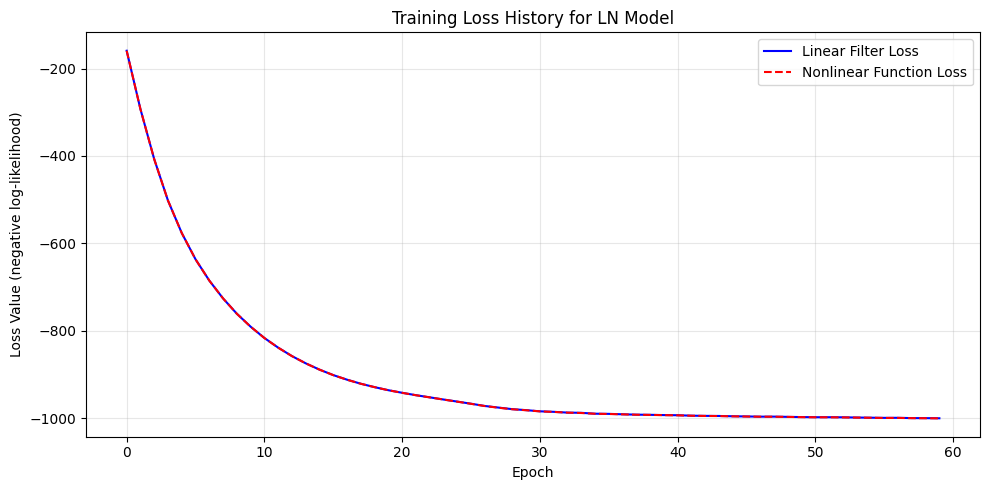

In [25]:
# Plot the training loss history
plt.figure(figsize=(10, 5))

# Extract losses
epochs = range(len(loss_history))
linear_losses = [loss[0] for loss in loss_history]
nonlinear_losses = [loss[1] for loss in loss_history]

# Plot both loss components
plt.plot(epochs, linear_losses, 'b-', label='Linear Filter Loss')
plt.plot(epochs, nonlinear_losses, 'r--', label='Nonlinear Function Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss Value (negative log-likelihood)')
plt.title('Training Loss History for LN Model')
plt.legend()
plt.grid(True, alpha=0.3)

# Add text showing final loss values
final_linear_loss = linear_losses[-1]
final_nonlinear_loss = nonlinear_losses[-1]

plt.tight_layout()
plt.show()

In [21]:
# --------------------- 评估 ---------------------
# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
W_m = trained_model.linear.W_m.detach().cpu().numpy()
alpha = trained_model.linear.alpha.detach().cpu().numpy()

with torch.no_grad():
    # Move model to the same device as input data
    trained_model = trained_model.to(device)
    # Convert stimulus to torch tensor with correct shape (batch, T, H, W)
    # Add batch dimension since the model expects it
    stimulus_tensor = torch.as_tensor(stimulus).float().unsqueeze(0).to(device)
    # Get predictions
    r_est = trained_model(stimulus_tensor).cpu().numpy().squeeze()

print(np.max(r_est), np.min(r_est), np.mean(r_est), np.std(r_est))
print(np.max(rate), np.min(rate), np.mean(rate), np.std(rate))
print(np.max(W_m), np.min(W_m), np.mean(W_m), np.std(W_m))
print(np.max(sta), np.min(sta), np.mean(sta), np.std(sta))
print(alpha)

# Convert stimulus to torch tensor before passing to the model
F = model.linear(stimulus_tensor).detach().cpu().numpy().squeeze()

max_F = np.max(F)
min_F = np.min(F)
mean_F = np.mean(F)
std_F = np.std(F)

print(f"线性输出最大值: {max_F:.4f}")
print(f"线性输出最小值: {min_F:.4f}")
print(f"线性输出均值: {mean_F:.4f}")
print(f"线性输出标准差: {std_F:.4f}")

Using device: cpu
2104.926 53.21922 101.18823 106.191795
192.32008513428886 0.0 4.074111346974513 14.770868244204403
1.4135495 -0.47099027 0.51989895 0.28508696
0.311187782638376 -0.016226977295919966 0.08027091947612137 0.05489597950637046
[-0.02510146  0.05673252  0.23053032 -0.1202075  -0.42499197  0.0648248
  0.29885486 -0.17491889]
线性输出最大值: 50.2368
线性输出最小值: -50.2628
线性输出均值: -0.0001
线性输出标准差: 3.7216


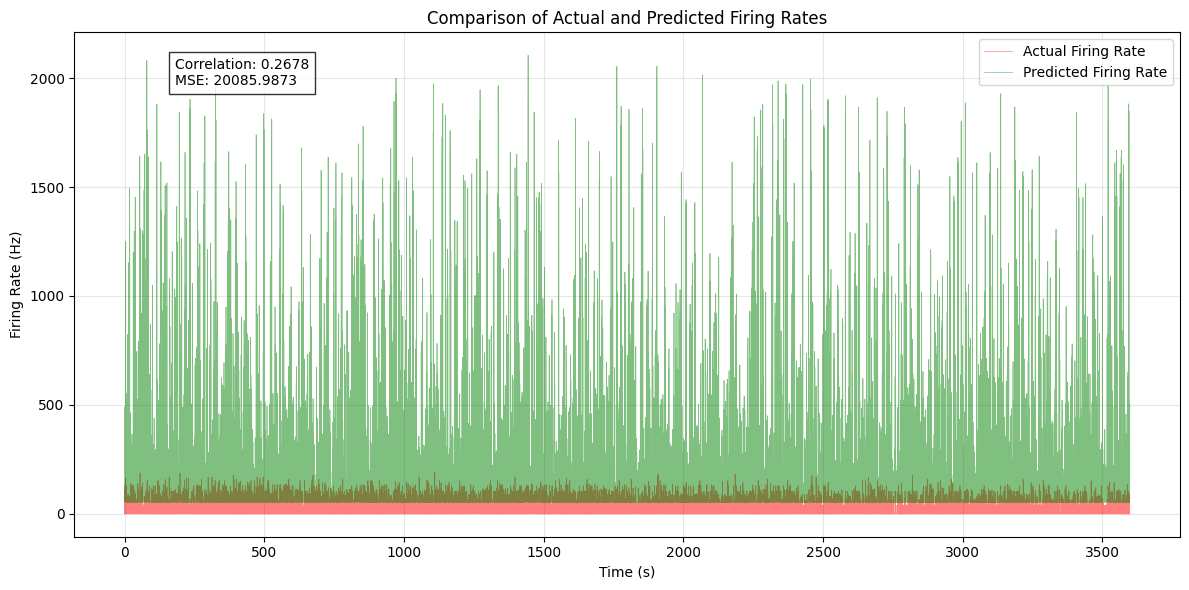

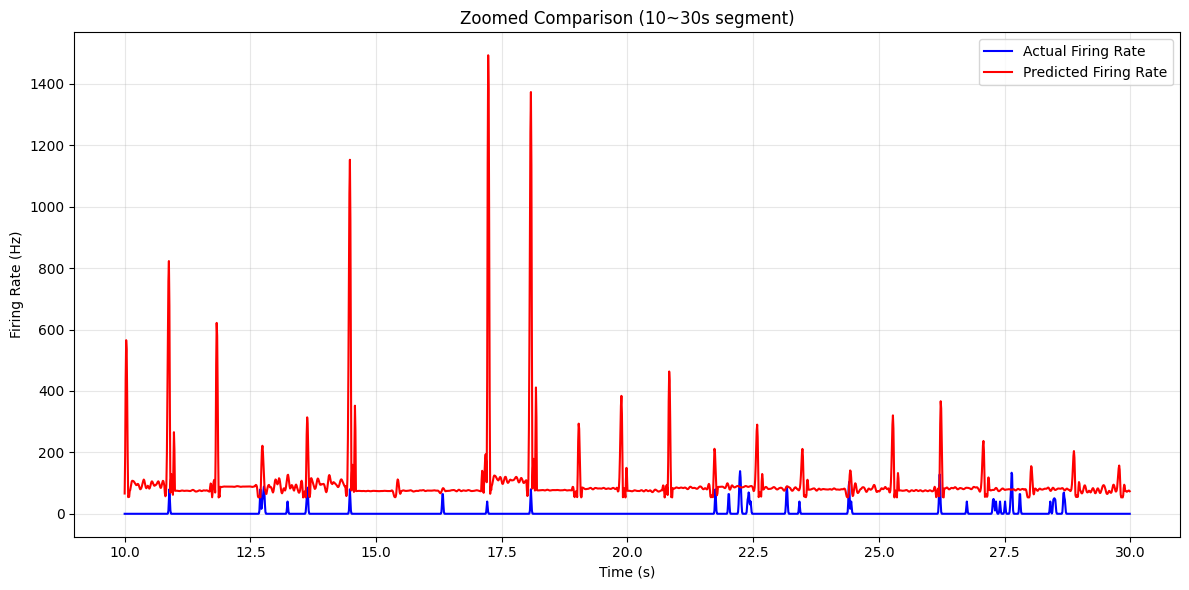

2104.926 53.21922 101.18823 106.191795
192.32008513428886 0.0 4.074111346974513 14.770868244204403
1465869.3367527768 359801
4.074111346974513
预测与真实发放率的相关系数： 0.2677769920089909
1.0385393 0.95824915 0.9998043 0.013944626


In [22]:
# Plot original firing rate and fitted results
plt.figure(figsize=(12, 6))
time_axis = np.arange(T) * 10 / 1000  # Convert to seconds

# Plot both on the same axes
plt.plot(time_axis, rate, 'r-', alpha=0.5, label='Actual Firing Rate', linewidth=0.5)
plt.plot(time_axis, r_est, 'g-', alpha=0.5, label='Predicted Firing Rate', linewidth=0.5)
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Firing Rate (Hz)')
plt.title('Comparison of Actual and Predicted Firing Rates')
plt.grid(True, alpha=0.3)

# For evaluation metrics, calculate correlation coefficient, mean squared error, and variance explained
correlation = np.corrcoef(rate, r_est)[0, 1]
mse = np.mean((rate - r_est)**2)
var_rate = np.var(rate)

# Add metrics as text
plt.figtext(0.15, 0.85, f'Correlation: {correlation:.4f}\nMSE: {mse:.4f}', bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Plot a zoom-in view of a segment to see details better
segment_start = 1000  # Start at 10 second
segment_length = 2000  # 20 seconds segment

plt.figure(figsize=(12, 6))
segment_time = time_axis[segment_start:segment_start+segment_length]
plt.plot(segment_time, rate[segment_start:segment_start+segment_length], 'b-', label='Actual Firing Rate')
plt.plot(segment_time, r_est[segment_start:segment_start+segment_length], 'r-', label='Predicted Firing Rate')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Firing Rate (Hz)')
plt.title('Zoomed Comparison (10~30s segment)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(np.max(r_est), np.min(r_est), np.mean(r_est), np.std(r_est))
print(np.max(rate), np.min(rate), np.mean(rate), np.std(rate))
print(sum_rate, T)
print(sum_rate / T)
corr = np.corrcoef(rate, r_est)[0,1]
print("预测与真实发放率的相关系数：", corr)

print(np.max(sigma_s2), np.min(sigma_s2), np.mean(sigma_s2), np.std(sigma_s2))



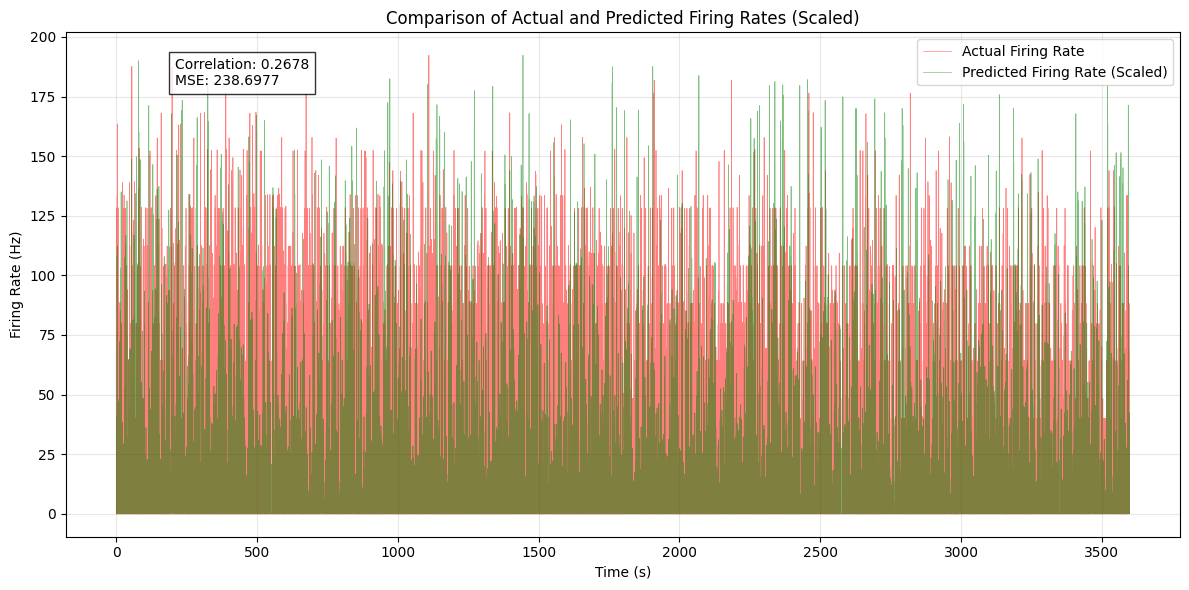

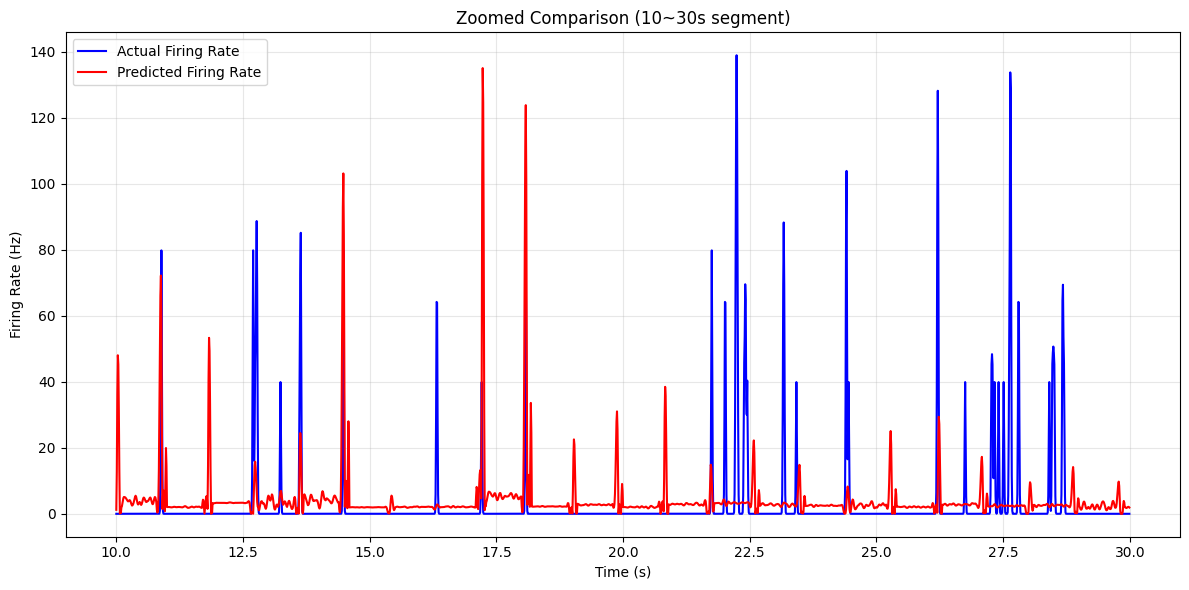

In [23]:
# 将预测值线性映射到真实值的范围内
def linear_scale(source, target_min, target_max):
    src_min = np.min(source)
    src_max = np.max(source)
    # 处理特殊情况：当预测值范围为零时
    if src_max - src_min < 1e-6:
        return np.full_like(source, (target_min + target_max)/2)
    scaled = (source - src_min) * (target_max - target_min) / (src_max - src_min) + target_min
    return np.clip(scaled, target_min, target_max)

# 获取真实值的范围
rate_min = np.min(rate)
rate_max = np.max(rate)

# 对预测结果进行线性缩放
r_est_scaled = linear_scale(r_est, rate_min, rate_max)

# Plot original firing rate and fitted results
plt.figure(figsize=(12, 6))
time_axis = np.arange(T) * 10 / 1000  # Convert to seconds

# Plot both on the same axes
plt.plot(time_axis, rate, 'r-', alpha=0.5, label='Actual Firing Rate', linewidth=0.5)
plt.plot(time_axis, r_est_scaled, 'g-', alpha=0.5, label='Predicted Firing Rate (Scaled)', linewidth=0.5)
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Firing Rate (Hz)')
plt.title('Comparison of Actual and Predicted Firing Rates (Scaled)')
plt.grid(True, alpha=0.3)

# For evaluation metrics, calculate correlation coefficient, mean squared error, and variance explained
correlation = np.corrcoef(rate, r_est_scaled)[0, 1]
mse = np.mean((rate - r_est_scaled)**2)
var_rate = np.var(rate)

# Add metrics as text
plt.figtext(0.15, 0.85, f'Correlation: {correlation:.4f}\nMSE: {mse:.4f}', bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Plot a zoom-in view of a segment to see details better
segment_start = 1000  # Start at 10 second
segment_length = 2000  # 20 seconds segment

plt.figure(figsize=(12, 6))
segment_time = time_axis[segment_start:segment_start+segment_length]
plt.plot(segment_time, rate[segment_start:segment_start+segment_length], 'b-', label='Actual Firing Rate')
plt.plot(segment_time, r_est_scaled[segment_start:segment_start+segment_length], 'r-', label='Predicted Firing Rate')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Firing Rate (Hz)')
plt.title('Zoomed Comparison (10~30s segment)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
  

### 根据结果，绘制N_m、W_m、T_m图像

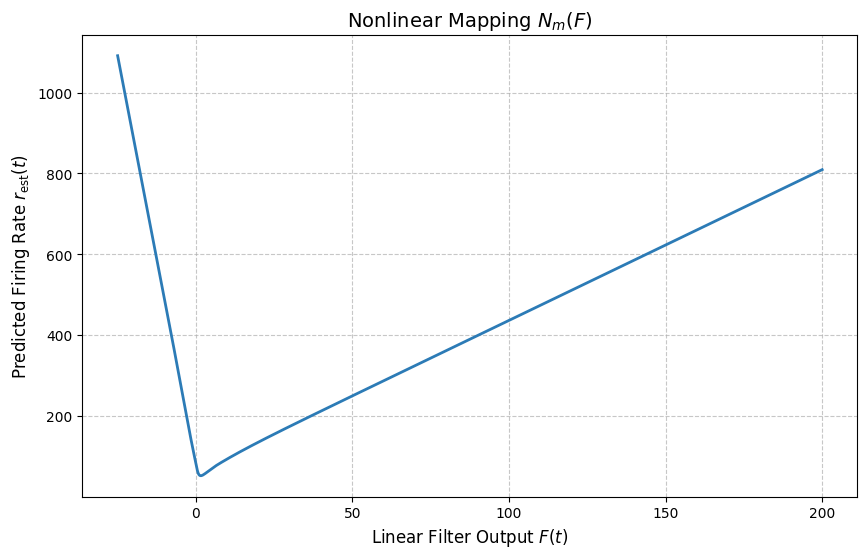

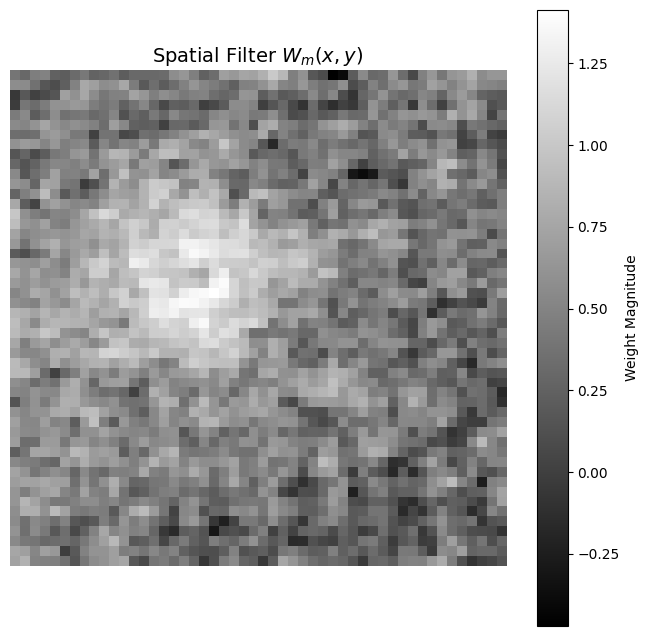

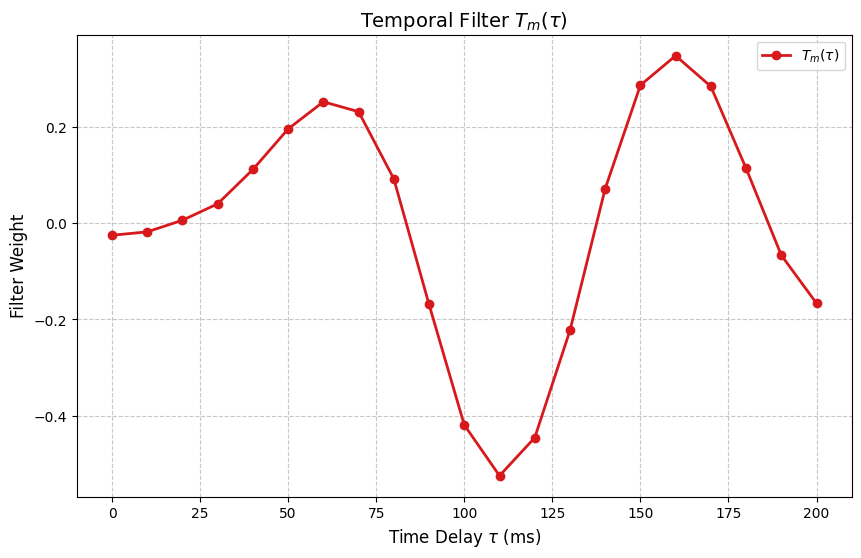

In [29]:
# 生成测试输入范围
F_test = torch.linspace(-25, 200, 1000).unsqueeze(-1).to(device)
with torch.no_grad():
    r_est_test = model.nonlinear(F_test).cpu().numpy()

# 绘制非线性映射曲线
plt.figure(figsize=(10, 6))
plt.plot(F_test.cpu().numpy(), r_est_test, linewidth=2, color='#2c7bb6')
plt.xlabel("Linear Filter Output $F(t)$", fontsize=12)
plt.ylabel("Predicted Firing Rate $r_{\\text{est}}(t)$", fontsize=12)
plt.title("Nonlinear Mapping $N_m(F)$", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# 绘制空间感受野
plt.figure(figsize=(8, 8))
plt.imshow(W_m, cmap='gray')
plt.colorbar(label="Weight Magnitude")
plt.title("Spatial Filter $W_m(x,y)$", fontsize=14)
plt.axis('off')
plt.show()

# 提取时间滤波器参数
T_m = model.linear.compute_T_m().detach().cpu().numpy()
time_axis = np.arange(num_tau) * 10  # 转换为毫秒

# 绘制时间响应曲线
plt.figure(figsize=(10, 6))
plt.plot(time_axis, T_m, 
         marker='o', 
         markersize=6,
         linewidth=2,
         color='#d7191c',
         label="$T_m(\\tau)$")

plt.xlabel("Time Delay $\\tau$ (ms)", fontsize=12)
plt.ylabel("Filter Weight", fontsize=12)
plt.title("Temporal Filter $T_m(\\tau)$", fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()